# Call Buy Indicator Code

In [333]:
###### Importing all packages #####################################
# optional installations: 
# !pip install yfinance --upgrade --no-cache-dir
# !pip3 install pandas_datareader
# !pip3 install matplotlib


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

import pandas_datareader.data as web
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
import time
import ssl
from urllib import request
import trading_calendars as tc
import pytz

#newest yahoo API 
import yfinance as yahoo_finance

#optional 
yahoo_finance.pdr_override()
%matplotlib inline

## Defining Functions

In this section functions for several technical indicators are coded:
1. RSI 
2. Stochastic Slow
3. MACD

In [478]:
def computeRSI(dataframe, time_window):
    
    '''RSI = Relative Strength Index (https://www.investopedia.com/terms/r/rsi.asp)'''
    
    diff = dataframe.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)

    return rsi


def stochastics(dataframe, low, high, close, k, d):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    
    https://www.investopedia.com/terms/s/stochasticoscillator.asp
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()
    df['d_div'] = df['d_fast'] - df['d_slow']

    return df

def MACD(dataframe,close,span1,span2,sig_span):
    
    """
    EMA = exponential moving average
    MACD = Moving Average Convergence Divergence = 12Period EMA - 26Period EMA
    Signal  = 9Period EMA of MACD
    
    https://www.investopedia.com/terms/m/macd.asp
    
    """
    
    df = dataframe.copy()
    exp1 = df[close].ewm(span=span1, adjust=False).mean()
    exp2 = df[close].ewm(span=span2, adjust=False).mean()
    macd = exp1-exp2
    exp3 = macd.ewm(span=sig_span, adjust=False).mean()
    df['MACD line'] = macd
    df['Sig Line'] = exp3
    df['MACD_Div'] = macd-exp3
    return df

def CBI_func(ticker, ticker_df, test_days, holding_days, vol_cutoff, vol_avg_window, 
             RSI_trend_days, RSI_low, RSI_hi, MACD_Div_trend_days, d_slow_trend_days, d_slow_low, d_slow_hi):
    """
    ticker - S&P500 ticker for which stock prices are obtained
    start_time - earliest date at which the stock_price is obtained from yfinance
    end_time - latest date at which the stock price is obtained from yfinance
    trade_date - a date between the start_time and end_time at which a hypothetical trade is entered

    All Technical Indicators are calculated with the "PAST" data and Price changes are calculated with the "FUTURE" data as defined below:
    start_time........................trade_date..........................end_time
    [..............PAST..............]          [...........FUTURE...............]

    CBI [Cumulative Buying Index]:
    - Average of scores calculated from value on trade date, slope and intercept of 'x' days before the trade date of the following Indicators: 
      - Stochastic slow - 14 day average
      - MACD Divergence - standard 12,26,9 day
    - Values closer to zero are strong indicators and the distance from zero defines the strength of the indicator, however, within small intervals 
      distance from zero may not necessarily correlate with strength. For eg: 
        - CBI of 0.1 and 0.5 is highly likely to indicate strong and weak buy respectively
        - CBI of 0.1 and 0.15 may not indicate that the former is a stronger buy than the latter

    """
    df0 = ticker_df
    
    # Call functions to calculate the Technical Indicators for each date (row) in the dataframe,...
    # append as columns to the same dataframe                                                                            
    df0['RSI'] = computeRSI(df0['Adj Close'], 14)
    df0 = stochastics( df0, 'Low', 'High', 'Close', 14, 3 )
    df0 = MACD(df0, 'Close', 12, 26, 9)
    
    df0['avg_volume'] = df0.iloc[:,6].rolling(window=vol_avg_window).mean()
    

    passed_trades = pd.DataFrame()
    
    # intializing dataframe
    column_names = ['Symbol', 'Trade_Date','CBI_SS','CBI_MACD','CBI','Trade_Price','Price_Delta', 
                    'Avg_Volume', 'RSI_val', 'RSI_slope, intercept', 'SS_val', 'SS_slope, intercept', 
                    'MSCD_Div_val', 'MACD_Div_slope, intercept']
    

    df0['Price_Delta'] = (df0['Close'].rolling(holding_days).max().shift(-holding_days+1) - df0['Close'])/df0['Close']*100.
    df0['Price_Delta'] = np.where(df0['Price_Delta']<=0., 
                                        (df0['Close'].rolling(holding_days).min().shift(-holding_days+1) 
                                         - df0['Close'])/df0['Close']*100., df0['Price_Delta'])
    
    for trade_date in test_days:
        if xnys.is_session(pd.Timestamp(trade_date, tz='UTC')):
            # Date to enter a trade
            day0 = trade_date

            CBIL = [] #Call Buying Indicator List
    
            #trade date values
            RSI_val = df0[df0['Date']==day0]['RSI'].values
            MACD_Div_val = df0[df0['Date']==day0]['MACD_Div'].values
            d_slow_val = df0[df0['Date']==day0]['d_slow'].values
            avg_volume = df0[df0['Date']==day0]['avg_volume'].values
            price_delta = df0[df0['Date']==day0]['Price_Delta'].values
            trade_date_price = df0[df0['Date']==day0]['Close'].values
            # print("RSI_val:", RSI_val)

    
            #slopes
            # Extract location of date
            j = df0.loc[(df0["Date"] == day0)].index.item()
            RSI_fit = slope_calculator(df0[j-RSI_trend_days:j+1], RSI_trend_days, day0, 'RSI') #num_days >=3
            MACD_Div_fit = slope_calculator(df0[j-MACD_Div_trend_days:j+1], MACD_Div_trend_days, day0, 'MACD_Div') #num_days >=3
            d_slow_fit = slope_calculator(df0[j-d_slow_trend_days:j+1], d_slow_trend_days, day0, 'd_slow') #num_days >=3
    
            # Vol and RSI crieria
            if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:
                CBIL.append(day0)
    
                # TECHNICAL INDICATORS ALGEBRA #
                if d_slow_val > d_slow_low and d_slow_val < d_slow_hi and d_slow_fit[0] > 0:
                    CBIL.append((abs(d_slow_val - 0.5*(d_slow_hi + d_slow_low))/(0.5*(d_slow_hi - d_slow_low))).item())
                else: 
                    CBIL.append(10.0)
    
                if MACD_Div_val < 0 and MACD_Div_fit[1] < 0 and MACD_Div_fit[0] > 0:
                    CBIL.append((MACD_Div_val/MACD_Div_fit[1]).item())
                else: 
                    CBIL.append(10.0)

      
                CBIL.append(trade_date_price)
                CBIL.append(price_delta)
                CBI = 0.5*(CBIL[1] + CBIL[2])
                CBIL.append(CBI)
                
                if CBIL[5] < 1.0:
                    output = [ticker, CBIL[0], CBIL[1], CBIL[2], CBIL[5], CBIL[3].item(), CBIL[4].item(), 
                              avg_volume, RSI_val.item(), RSI_fit, d_slow_val.item(), d_slow_fit, MACD_Div_val.item(), MACD_Div_fit]
                    passed = pd.DataFrame([output], columns=column_names)
                    passed_trades = passed_trades.append(passed, ignore_index = True)
        
            
    return passed_trades

    

def slope_calculator(dataframe, num_days, trade_date, indicator):
    if num_days < 3:
        print("\nError: num_days should be more than or equal to 3\n")
        exit()

    df = dataframe.copy()
    df['Date'] = pd.to_datetime(df['Date'])
  
    Y = np.array(df[indicator].iloc[-1*num_days:-1])
    X = np.array([n for n in range(0, len(Y))])
    Z = np.polyfit(X,Y,1)
    return Z
  

## Main Code - Testing for 1 Ticker

TEST CODE: In this section, a single ticker is analyzed for a range of dates

In [341]:
xnys = tc.get_calendar("XNYS")

# start_time and end_time to fetch data from yahoo
start_time = '2019-11-14'
end_time = '2021-04-01'

# start and end dates of trading period
trade_days_start = '2020-01-01'
trade_days_end = '2020-10-27'

ticker_list = ['MMM']

test_days = pd.bdate_range(trade_days_start, trade_days_end)

#print(test_days)
#CBI_all = []

for ticker in ticker_list:
    # Get Stock Prices for the ticker between start_time and end_time
    connected = False
    while not connected:
        try:
            ticker_df = web.get_data_yahoo(ticker_list, start=start_time, end=end_time)
            connected = True;
        except Exception as e:
            print("Ticker: ", ticker,"  >>  Error: " + str(e))
            continue        
    
    ticker_df.reset_index(inplace=True)
    

    try:
        output = CBI_func(ticker, ticker_df, test_days, holding_days = 15, vol_cutoff = 2.0e6, 
                          vol_avg_window = 7, RSI_trend_days = 7, RSI_low = 40., RSI_hi = 75., MACD_Div_trend_days = 4, 
                          d_slow_trend_days = 4, d_slow_low = 10., d_slow_hi = 50.)
    except Exception as e:
        print('Analyzed Security: ',ticker, 'No Data')
        #print("Ticker: ", ticker,"  >>  Error: " + str(e))
        no_data_tickers.append(ticker)
        #traceback.print_exc()
        continue
        
output.head()

[*********************100%***********************]  1 of 1 completed


,Symbol,Trade_Date,CBI_SS,CBI_MACD,CBI,Trade_Price,Price_Delta,Avg_Volume,RSI_val,"RSI_slope, intercept",SS_val,"SS_slope, intercept",MSCD_Div_val,"MACD_Div_slope, intercept"
0,MMM,2020-02-12,0.490241,0.242008,0.366125,163.800003,-11.330890,[3056914.285714286],42.086999,"[2.0580658813362684, 28.4009355488776]",20.195171,"[1.7526250176431097, 16.20757917367276]",-0.353430,"[0.33588235540566663, -1.4604050838819957]"
1,MMM,2020-02-14,0.307809,0.199320,0.253565,161.009995,-9.794416,[2794814.285714286],41.042598,"[1.0814093309851083, 34.492731792365525]",23.843810,"[1.2669142923891203, 19.14699418534613]",-0.140608,"[0.2318415672173416, -0.7054349927734085]"
2,MMM,2020-03-04,0.224033,0.037959,0.130996,153.979996,-23.451094,[7466057.142857143],45.393604,"[1.8702996749706422, 26.523129873906605]",25.519330,"[3.830828083542616, 14.019898743246213]",-0.023277,"[0.09029869456760897, -0.6132065829983044]"
3,MMM,2020-05-19,0.181802,0.168215,0.175008,148.380005,12.825177,[5280057.142857143],54.020027,"[0.7811193028731969, 42.38641053581657]",33.636034,"[3.693036343056455, 9.144954312623426]",-0.304998,"[0.4469252257783983, -1.8131396305778507]"
4,MMM,2020-07-01,0.025743,0.629512,0.327628,155.429993,3.261923,[2420571.4285714286],50.007531,"[0.057946678112919744, 48.77493651297343]",30.514867,"[0.3908465400223808, 21.393466436387072]",-0.809604,"[0.1805925365993553, -1.286082428266486]"


## MAIN CODE - Full SP500

In [335]:
url="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
##START - only needed when  getting SSLVerificationError in local##
context = ssl._create_unverified_context()
response = request.urlopen(url, context=context)
html = response.read()
##END - only needed when  getting SSLVerificationError in local##
table=pd.read_html(html)
sp500 = table[0]
sp500 = sp500[['Symbol','Security','GICS Sector']]
sector_list = list(sp500['GICS Sector'].unique())
print(sector_list)
sp500.head(5)

['Industrials', 'Health Care', 'Information Technology', 'Communication Services', 'Consumer Discretionary', 'Utilities', 'Financials', 'Materials', 'Real Estate', 'Consumer Staples', 'Energy']


,Symbol,Security,GICS Sector
0,MMM,3M Company,Industrials
1,ABT,Abbott Laboratories,Health Care
2,ABBV,AbbVie Inc.,Health Care
3,ABMD,Abiomed,Health Care
4,ACN,Accenture,Information Technology


In [482]:
# dropping tickers with . like BRK.B
sp500 = sp500[sp500['Symbol'] != "."]

# intializing dataframe
column_names = ['Symbol', 'Trade_Date','CBI_SS','CBI_MACD','CBI','Trade_Price','Price_Delta', 
                'Avg_Volume', 'RSI_val', 'RSI_slope, intercept', 'SS_val', 'SS_slope, intercept', 
                'MSCD_Div_val', 'MACD_Div_slope, intercept']

passed_trades = pd.DataFrame()

# import NYSE calendar
xnys = tc.get_calendar("XNYS")


# start_time and end_time to fetch data from yahoo
start_time = '2020-10-01'
end_time = '2021-04-18'

# start and end dates of trading period
trade_days_start = '2021-04-12'
trade_days_end = '2021-04-16'
test_days = pd.bdate_range(trade_days_start, trade_days_end)

#sector_list = ['Energy']
#ticker_list = ['APA']

sector_list = list(sp500['GICS Sector'].unique())
count = 0
total = sp500['Symbol'].nunique()

for sector in sector_list:
    ticker_list = list(sp500[sp500['GICS Sector']==sector]['Symbol'])
    for ticker in ticker_list:
        count = count + 1
        connected = False
        while not connected:
            try:
                ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
                connected = True;
            except Exception as e:
                print("Ticker: ", ticker,"  >>  Error: " + str(e))
                continue 
        ticker_df.reset_index(inplace=True)
        print('Analyzing Security: ',ticker, '......',count,'/',total)
        
        try:
            output = CBI_func(ticker, ticker_df, test_days, holding_days = 1, vol_cutoff = 2.0e6, 
                              vol_avg_window = 7, RSI_trend_days = 7, RSI_low = 40., RSI_hi = 75., MACD_Div_trend_days = 4, 
                              d_slow_trend_days = 4, d_slow_low = 10., d_slow_hi = 50.)
            
            passed_trades = passed_trades.append(output, ignore_index = True)
            
        except Exception as e:
            print('Analyzed Security: ',ticker, 'No Data')
            no_data_tickers.append(ticker)
            #traceback.print_exc()
            continue
                

passed_trades = passed_trades.merge(sp500, how='left',on='Symbol')
passed_trades.head()

run_time = datetime.datetime.now().date().isoformat()
filename = 'sp500_passed_trades2018'+str(run_time)+'.csv'
passed_trades.to_csv(filename)
#sp500.to_csv('sp500.csv')

[*********************100%***********************]  1 of 1 completed
Analyzing Security:  MMM ...... 1 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  ALK ...... 2 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  ALLE ...... 3 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  AAL ...... 4 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  AME ...... 5 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  AOS ...... 6 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  BA ...... 7 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  CHRW ...... 8 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  CARR ...... 9 / 505
[****************

[*********************100%***********************]  1 of 1 completed
Analyzing Security:  ABT ...... 75 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  ABBV ...... 76 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  ABMD ...... 77 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  A ...... 78 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  ALXN ...... 79 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  ALGN ...... 80 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  ABC ...... 81 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  AMGN ...... 82 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  ANTM ...... 83 / 505
[*****

[*********************100%***********************]  1 of 1 completed
Analyzing Security:  ADSK ...... 148 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  ADP ...... 149 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  AVGO ...... 150 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  BR ...... 151 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  CDNS ...... 152 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  CDW ...... 153 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  CSCO ...... 154 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  CTXS ...... 155 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  CTSH ...... 156 / 

[*********************100%***********************]  1 of 1 completed
Analyzing Security:  EA ...... 221 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  FB ...... 222 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  FOXA ...... 223 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  FOX ...... 224 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  IPG ...... 225 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  LYV ...... 226 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  LUMN ...... 227 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  NFLX ...... 228 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  NWSA ...... 229 / 505

[*********************100%***********************]  1 of 1 completed
Analyzing Security:  UAA ...... 295 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  UA ...... 296 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  VFC ...... 297 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  WHR ...... 298 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  WYNN ...... 299 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  YUM ...... 300 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  AES ...... 301 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  LNT ...... 302 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  AEE ...... 303 / 505
[

[*********************100%***********************]  1 of 1 completed
Analyzing Security:  MET ...... 368 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  MCO ...... 369 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  MS ...... 370 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  MSCI ...... 371 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  NDAQ ...... 372 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  NTRS ...... 373 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  PBCT ...... 374 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  PNC ...... 375 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  PFG ...... 376 / 50

[*********************100%***********************]  1 of 1 completed
Analyzing Security:  O ...... 442 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  REG ...... 443 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  SBAC ...... 444 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  SPG ...... 445 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  UDR ...... 446 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  VTR ...... 447 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  VNO ...... 448 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  WELL ...... 449 / 505
[*********************100%***********************]  1 of 1 completed
Analyzing Security:  WY ...... 450 / 505
[*

In [488]:
passed_trades.sort_values(by=['Trade_Date', 'CBI'], ascending=False, inplace=True)
passed_trades[passed_trades['CBI']<0.30].head(15)

,Symbol,Trade_Date,CBI_SS,CBI_MACD,CBI,Trade_Price,Price_Delta,Avg_Volume,RSI_val,"RSI_slope, intercept",SS_val,"SS_slope, intercept",MSCD_Div_val,"MACD_Div_slope, intercept",Security,GICS Sector
1,CNC,2021-04-16,0.311643,0.110780,0.211211,64.959999,0.0,[3505485.714285714],61.027547,"[2.1412156597170555, 43.602495821572425]",36.232858,"[3.2212800817577985, 19.059430861225643]",-0.043267,"[0.09354887198116749, -0.390568950470802]",Centene Corporation,Health Care
18,APA,2021-04-16,0.318480,0.036866,0.177673,17.799999,0.0,[6223257.142857143],45.098444,"[1.4429998039295253, 39.15093718211197]",36.369603,"[5.8511423390854045, 10.037722562830384]",-0.006022,"[0.06934979435467205, -0.16335438702331653]",APA Corporation,Energy
9,FOXA,2021-04-15,0.106471,0.467088,0.286779,37.884998,0.0,[2992700.0],49.664035,"[0.20816727937865925, 45.3996517045446]",32.129422,"[2.318044830533185, 22.538654993538238]",-0.206385,"[0.07313428098521745, -0.441854751614802]",Fox Corporation (Class A),Communication Services
22,NOV,2021-04-15,0.065989,0.160348,0.113168,13.440000,0.0,[3746542.8571428573],43.562692,"[0.5675009231546562, 38.77859844905144]",31.319775,"[1.7204508731130599, 18.83852286787208]",-0.019266,"[0.03485471646093501, -0.12014976354915625]",NOV Inc.,Energy


## Plots

,Unnamed: 0,Symbol,Trade_Date,CBI_SS,CBI_MACD,CBI,Trade_Price,Price_Delta,Avg_Volume,RSI_val,"RSI_slope, intercept",SS_val,"SS_slope, intercept",MSCD_Div_val,"MACD_Div_slope, intercept",Security,GICS Sector
0,0,MMM,2018-02-14,0.330662,0.592543,0.461603,232.000000,5.232758,[3487914.28571429],41.760385,[ 0.80970835 33.32876019],23.386764,[ 0.81556 15.05324172],-2.008746,[ 0.42437284 -3.39004014],3M Company,Industrials
1,1,MMM,2018-02-15,0.010706,0.460002,0.235354,234.869995,3.946866,[3062114.28571429],47.463980,[ 2.01648945 31.13682907],30.214112,[ 4.61974671 13.73997377],-1.390442,[ 0.50770254 -3.02268566],3M Company,Industrials
2,2,MMM,2018-02-16,0.277403,0.315100,0.296252,236.669998,3.156294,[2967285.71428571],49.720522,[ 3.67114893 28.84584819],35.548063,[ 6.33449227 17.3808421 ],-0.797588,[ 0.56080536 -2.53121884],3M Company,Industrials
3,3,MMM,2018-02-20,0.537273,0.232938,0.385106,235.070007,3.858422,[2813657.14285714],47.756948,[ 3.38875508 33.12910423],40.745461,[ 6.08064969 23.63566324],-0.466926,[ 0.60557892 -2.00450417],3M Company,Industrials
4,4,MMM,2018-02-21,0.737409,0.296416,0.516913,232.179993,5.151179,[2534057.14285714],44.349933,[ 2.3372515 38.39296069],44.748188,[ 5.26567435 30.23687089],-0.399196,[ 0.46175812 -1.34674333],3M Company,Industrials


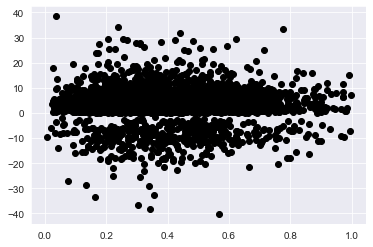

In [469]:
passed_trades = pd.read_csv('sp500_passed_trades2018_2021-04-18.csv')
x = passed_trades['CBI']
y = passed_trades['Price_Delta'].values
plt.plot(x,y,'o', color='black')
passed_trades.head(5)

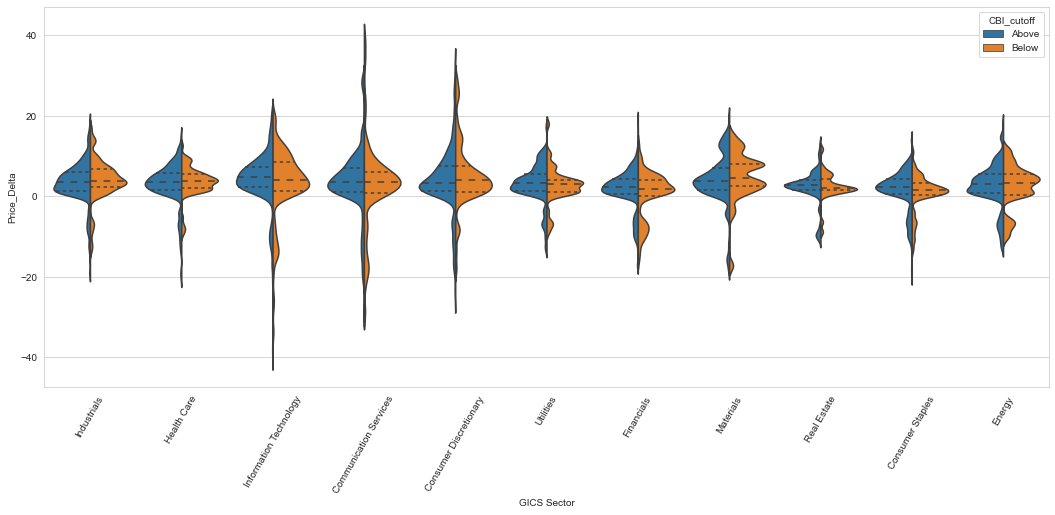

In [470]:
CBI_limit = 0.25
passed_trades['CBI_cutoff'] = np.where(passed_trades['CBI']<=CBI_limit, 'Below', 'Above')
import seaborn as sns
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(18, 7))
plt.xticks(rotation=60)
ax=sns.violinplot(x="GICS Sector", y="Price_Delta", data=passed_trades, 
                  inner="quartile", split=True, hue='CBI_cutoff', scale='width', bw=0.2)

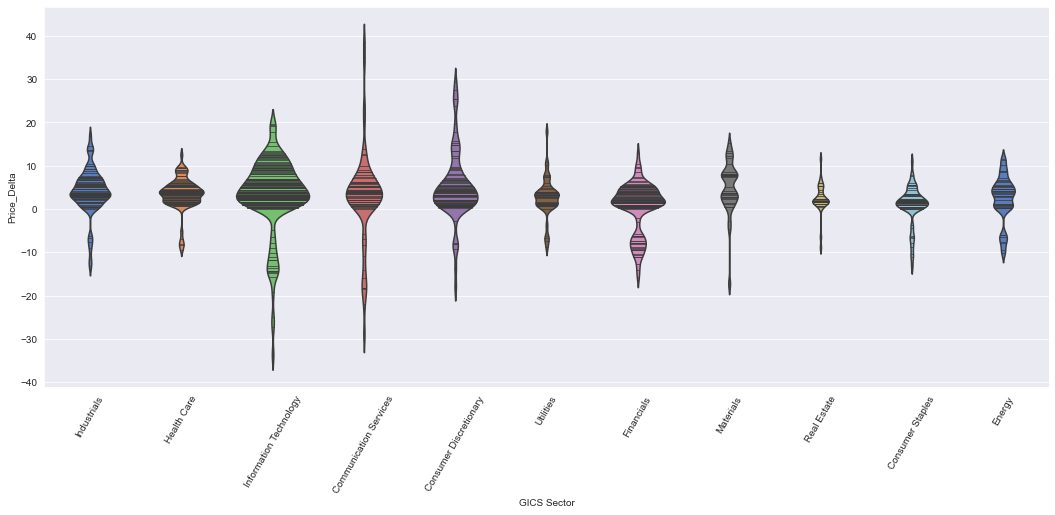

In [471]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(18, 7))
plt.xticks(rotation=60)
ax=sns.violinplot(x="GICS Sector", y="Price_Delta", data=passed_trades[passed_trades['CBI']<=CBI_limit], 
                  inner="sticks", scale='count', bw=0.2, palette='muted')


               Profit or Loss Price_Delta
                        count        mean
Profit or Loss                           
Loss                      100  -10.243662
Profit                    667    4.914190
Expected norm return =  2.9379380521383736 % in 3 weeks
Expected total return =  22.533984859901327 investement =  767


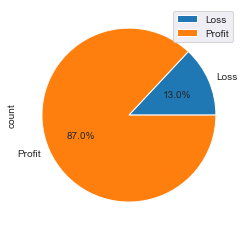

In [477]:
CBI_limit = .25
passed_trades_limit = passed_trades[passed_trades['CBI']<=CBI_limit]
passed_trades['Profit or Loss'] = np.where(passed_trades['Price_Delta']>0., 'Profit', 'Loss')

data = passed_trades_limit.groupby("Profit or Loss").agg({'Profit or Loss': ['count'], 'Price_Delta': 'mean'})
data.plot.pie(y='Profit or Loss', autopct="%.1f%%");
print(data)
data.reset_index(inplace=True)
print("Expected norm return = ",(data.iloc[1,1]*data.iloc[1,2]+data.iloc[0,1]*data.iloc[0,2])/(data.iloc[1,1]+data.iloc[0,1]),"% in 3 weeks")
print("Expected total return = ",(data.iloc[1,1]*data.iloc[1,2]/100+data.iloc[0,1]*data.iloc[0,2]/100),"investement = ", (data.iloc[1,1]+data.iloc[0,1]))

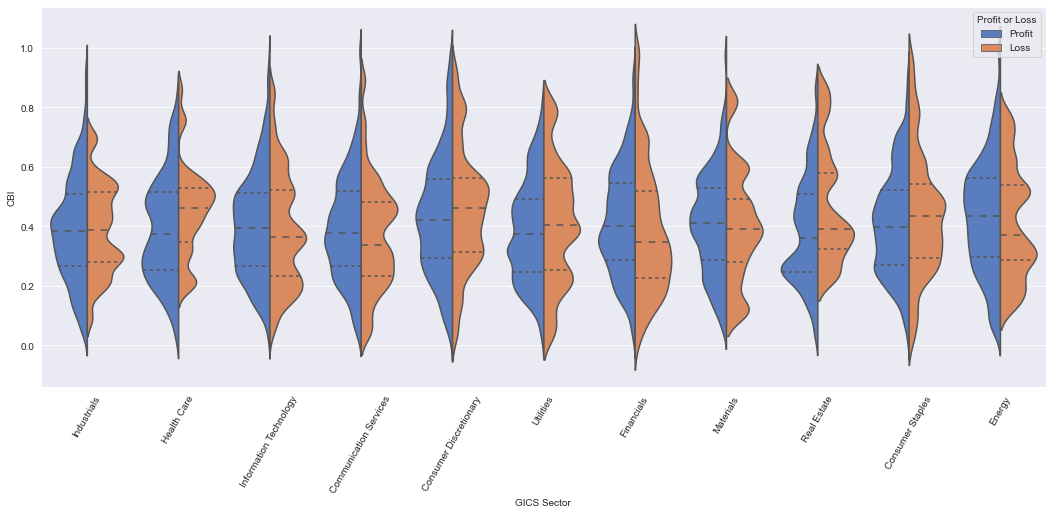

In [474]:

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(18, 7))
plt.xticks(rotation=60)
ax=sns.violinplot(x="GICS Sector", y="CBI", data=passed_trades, hue='Profit or Loss',
                  inner="quartile", scale='width', bw=0.2, palette='muted', split=True)